In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
# import tensorflow as tf

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# With eager execution, we just perform operations directly
a = tf.constant(5.0)
b = tf.constant(3.0)
c = a + b

# sess = tf.Session()
# Build a graph.
a = tf.constant(5.0)
b = tf.constant(6.0)
c = a * b

# Launch the graph in a session.
sess = tf.compat.v1.Session()

# Evaluate the tensor `c`.
# print(sess.run(c))

import các thư viện cần thiết cho huấn luyện mô hình

In [ ]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import seaborn as sns

from scipy import ndimage
from subprocess import check_output

import cv2


pal = sns.color_palette()

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

công cụ hỗ trợ việc tạo và tùy chỉnh các biểu đồ

In [ ]:
iris = datasets.load_iris()
x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals = np.array([1 if y==0 else -1 for y in iris.target])
class1_x = [x[0] for i,x in enumerate(x_vals) if
y_vals[i]==1]
class1_y = [x[1] for i,x in enumerate(x_vals) if
y_vals[i]==1]
class2_x = [x[0] for i,x in enumerate(x_vals) if
y_vals[i]==-1]
class2_y = [x[1] for i,x in enumerate(x_vals) if
y_vals[i]==-1]

Chia dữ liệu Iris thành hai lớp dựa trên giá trị y_vals, sau đó lưu trữ các giá trị x và y của từng lớp để dễ dàng trực quan hóa.

In [ ]:
batch_size = 100
x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None, 2],
dtype=tf.float32)
b = tf.Variable(tf.random_normal(shape=[1,batch_size]))

lấy tập dữ liệu và nhãn từ thuộc tính placehoder

In [ ]:
gamma = tf.constant(-10.0) # feel free to explore different values of gamma
dist = tf.reduce_sum(tf.square(x_data), 1)
dist = tf.reshape(dist, [-1,1])
sq_dists = tf.add(tf.subtract(dist, tf.multiply(2., tf.matmul(x_data,
tf.transpose(x_data)))), tf.transpose(dist))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))
#We now compute the loss for the dual optimization problem, as follows:
model_output = tf.matmul(b, my_kernel)
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = tf.matmul(y_target, tf.transpose(y_target))
second_term = tf.reduce_sum(tf.multiply(my_kernel,
tf.multiply(b_vec_cross, y_target_cross)))
loss = tf.negative(tf.subtract(first_term, second_term))

Dòng này tính toán hàm mất mát cho bài toán tối ưu hóa kép, sử dụng loss làm mục tiêu để tìm siêu phẳng phân tách lớp dữ liệu.

In [ ]:
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1),[-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1),
[-1,1])
pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data,
tf.transpose(prediction_grid)))), tf.transpose(rB))

Tính ma trận khoảng cách bình phương giữa các điểm trong x_data và prediction_grid để đo sự tương đồng giữa điểm dữ liệu và điểm dự đoán.

In [ ]:
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))
prediction_output =tf.matmul(tf.multiply(tf.transpose(y_target),b), pred_kernel)

Dùng ma trận kernel giữa các điểm trong x_data và prediction_grid để tính toán dự đoán đầu ra và xác định sự tương đồng giữa các điểm.

In [ ]:
prediction = tf.sign(prediction_output-tf.reduce_mean(prediction_output))

Phân loại đầu ra dự đoán bằng cách so sánh sự khác biệt giữa prediction_output và giá trị trung bình của nó.

In [ ]:
accuracy =tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction),tf.squeeze(y_target)), tf.float32))

Tính độ chính xác của mô hình bằng cách so sánh dự đoán prediction với nhãn thực tế y_target và tính tỷ lệ phần trăm dự đoán chính xác.

In [ ]:
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)
init = tf.global_variables_initializer() # this line is different depending on your version of tf
sess.run(init)

Sử dụng optimizer với Gradient Descent và cấu hình bước huấn luyện train_step để tối ưu hóa hàm mất mát, sau đó khởi tạo các biến trong mô hình và bắt đầu quá trình huấn luyện.

In [ ]:
loss_vec = []
batch_accuracy = []
for i in range(300):
    rand_index = np.random.choice(len(x_vals),size=batch_size)
    rand_x = x_vals[rand_index]
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target:rand_y})
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x,y_target: rand_y})
    loss_vec.append(temp_loss)
    acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x,y_target:rand_y,prediction_grid:rand_x})
    batch_accuracy.append(acc_temp)

Mỗi vòng lặp huấn luyện cập nhật trọng số bằng Gradient Descent, tính toán và lưu trữ giá trị mất mát và độ chính xác để theo dõi sự cải thiện hiệu suất của mô hình.

In [ ]:
x_min, x_max = x_vals[:, 0].min() - 1, x_vals[:, 0].max() + 1
y_min, y_max = x_vals[:, 1].min() - 1, x_vals[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]
[grid_predictions] = sess.run(prediction, feed_dict={x_data:rand_x,y_target:rand_y,prediction_grid: grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)

Tạo lưới điểm trong không gian đặc trưng, sử dụng mô hình huấn luyện để dự đoán cho các điểm này, và lưu các dự đoán trong grid_predictions để trực quan hóa quyết định phân loại.

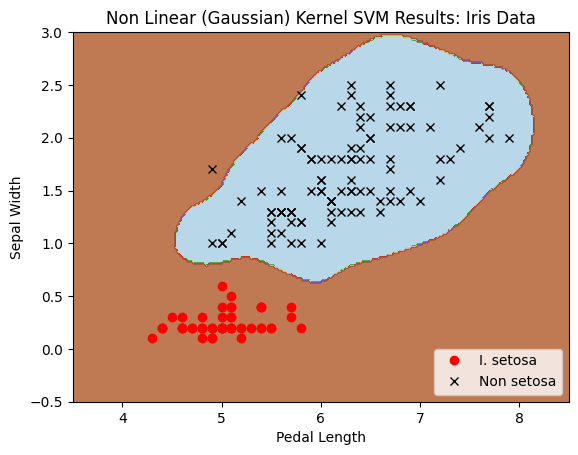

In [ ]:
plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired,
alpha=0.8)
plt.plot(class1_x, class1_y, 'ro', label='I. setosa')
plt.plot(class2_x, class2_y, 'kx', label='Non setosa')
plt.title('Non Linear (Gaussian) Kernel SVM Results: Iris Data')
plt.xlabel('Pedal Length')
plt.ylabel('Sepal Width')
plt.legend(loc='lower right')
plt.ylim([-0.5, 3.0])
plt.xlim([3.5, 8.5])
plt.show()

Đoạn mã tạo biểu đồ phân loại 2D thể hiện các vùng quyết định của mô hình SVM với kernel Gaussian, mô phỏng cách phân loại dữ liệu.

In [ ]:
iris = datasets.load_iris()
x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals1 = np.array([1 if y==0 else -1 for y in iris.target])
y_vals2 = np.array([1 if y==1 else -1 for y in iris.target])
y_vals3 = np.array([1 if y==2 else -1 for y in iris.target])
y_vals = np.array([y_vals1, y_vals2, y_vals3])
class1_x = [x[0] for i,x in enumerate(x_vals) if
iris.target[i]==0]
class1_y = [x[1] for i,x in enumerate(x_vals) if
iris.target[i]==0]
class2_x = [x[0] for i,x in enumerate(x_vals) if
iris.target[i]==1]
class2_y = [x[1] for i,x in enumerate(x_vals) if
iris.target[i]==1]
class3_x = [x[0] for i,x in enumerate(x_vals) if
iris.target[i]==2]
class3_y = [x[1] for i,x in enumerate(x_vals) if
iris.target[i]==2]

Đoạn mã tạo biểu đồ phân loại 2D thể hiện các vùng quyết định của mô hình SVM với kernel Gaussian, mô phỏng cách phân loại dữ liệu.

In [ ]:
batch_size = 50
x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[3, None], dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None, 2],dtype=tf.float32)
b = tf.Variable(tf.random_normal(shape=[3,batch_size]))

Đoạn mã sử dụng TensorFlow để chuẩn bị placeholder và biến cho mô hình phân loại, với mỗi placeholder đại diện cho dữ liệu cần thiết và biến b chứa trọng số mô hình.

In [ ]:
gamma = tf.constant(-1.0)
dist = tf.reduce_sum(tf.square(x_data), 1)
dist = tf.reshape(dist, [-1,1])
sq_dists = tf.add(tf.subtract(dist, tf.multiply(2., tf.matmul(x_data,tf.transpose(x_data)))), tf.transpose(dist))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))

Thực hiện tính toán kernel Gauss (RBF kernel) để đo sự tương đồng giữa các điểm dữ liệu dựa trên khoảng cách Euclid:

Tính tổng bình phương các đặc trưng trong x_data.
Tính khoảng cách bình phương giữa các điểm dữ liệu.
Tính kernel Gauss dựa trên khoảng cách và hằng số gamma.

In [ ]:
#batch multiplication
def reshape_matmul(mat):
    v1 = tf.expand_dims(mat, 1)
    v2 = tf.reshape(v1, [3, batch_size, 1])
    return(tf.matmul(v2, v1))

định nghĩa một hàm reshape_matmul phép nhân ma trận theo batch trong TensorFlow

In [ ]:
#loss
model_output = tf.matmul(b, my_kernel)
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = reshape_matmul(y_target)
second_term = tf.reduce_sum(tf.multiply(my_kernel,tf.multiply(b_vec_cross, y_target_cross)),[1,2])
loss = tf.reduce_sum(tf.negative(tf.subtract(first_term, second_term)))

gồm hai phần chính:
- first_term: một phần là tổng trọng số trong mô hình
- second_term: một phần liên quan đến các phép toán nhân giữa kernel, trọng số và nhãn mục tiêu

In [ ]:
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1),[-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1),[-1,1])

pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data,tf.transpose(prediction_grid)))), tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

Tính toán kernel Gaussian trong không gian đặc trưng để đo độ tương đồng giữa các điểm dữ liệu.

In [ ]:
prediction_output = tf.matmul(tf.multiply(y_target,b),pred_kernel)
prediction = tf.arg_max(prediction_output-tf.expand_dims(tf.reduce_mean(prediction_output,1), 1), 0)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction,tf.argmax(y_target,0)), tf.float32))

Instructions for updating:
Use `tf.math.argmax` instead


Dự đoán các điểm dữ liệu dựa trên đầu ra của mô hình, chuẩn hóa và tính giá trị dự đoán cuối cùng.
Tính độ chính xác của mô hình bằng cách so sánh dự đoán với nhãn thực tế và tính tỷ lệ chính xác.

In [ ]:
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)
init = tf.global_variables_initializer()
sess.run(init)

Khởi tạo bộ tối ưu hóa với thuật toán Gradient Descent và tốc độ học 0.01.
Xác định các phép toán tối ưu để giảm thiểu hàm mất mát.
Khởi tạo các biến trong mô hình và chuẩn bị cho huấn luyện.

In [ ]:
loss_vec = []
batch_accuracy = []

khởi tạo mảng rỗng chứa vector hàm mất mát và chứa dự đoán độ chính xác

In [ ]:
for i in range(1000):
    rand_index = np.random.choice(len(x_vals),
    size=batch_size)
    rand_x = x_vals[rand_index]
    rand_y = y_vals[:,rand_index]
    sess.run(train_step, feed_dict={x_data: rand_x, y_target:rand_y})
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x,y_target: rand_y})
    loss_vec.append(temp_loss)
    acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x,y_target: rand_y, prediction_grid:rand_x})
    batch_accuracy.append(acc_temp)
    if (i+1)%5==0:
        print('Step #' + str(i+1))
        print('Loss = ' + str(temp_loss))

Step #5
Loss = 81.91129
Step #10
Loss = 39.1155
Step #15
Loss = 27.430357
Step #20
Loss = 3.444551
Step #25
Loss = 5.342228
Step #30
Loss = 8.643749
Step #35
Loss = -6.695982
Step #40
Loss = -9.462782
Step #45
Loss = -10.694457
Step #50
Loss = -10.658491
Step #55
Loss = -10.912077
Step #60
Loss = -12.47123
Step #65
Loss = -12.500689
Step #70
Loss = -12.104557
Step #75
Loss = -11.117134
Step #80
Loss = -12.138352
Step #85
Loss = -12.345854
Step #90
Loss = -13.291373
Step #95
Loss = -12.862368
Step #100
Loss = -14.009859
Step #105
Loss = -13.164259
Step #110
Loss = -11.817795
Step #115
Loss = -12.700555
Step #120
Loss = -11.642889
Step #125
Loss = -11.726908
Step #130
Loss = -13.116382
Step #135
Loss = -12.887291
Step #140
Loss = -12.709426
Step #145
Loss = -10.726498
Step #150
Loss = -14.486149
Step #155
Loss = -13.315144
Step #160
Loss = -14.257942
Step #165
Loss = -11.631937
Step #170
Loss = -14.155037
Step #175
Loss = -13.482585
Step #180
Loss = -13.11361
Step #185
Loss = -13.261816


sử dụng mini-batch gradient descent, mô hình cập nhật các trọng số qua mỗi vòng lặp để giảm hàm mất mát và cải thiên độ chính xác

In [ ]:
x_min, x_max = x_vals[:, 0].min() - 1, x_vals[:, 0].max() + 1
y_min, y_max = x_vals[:, 1].min() - 1, x_vals[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
np.arange(y_min, y_max, 0.02))

grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_predictions = sess.run(prediction, feed_dict={x_data:rand_x,y_target:rand_y,prediction_grid: grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)

dự đoán nhãn cho từng điểm trên lưới để có thể vẽ vùng phân loại của mô hình trên đồ thị

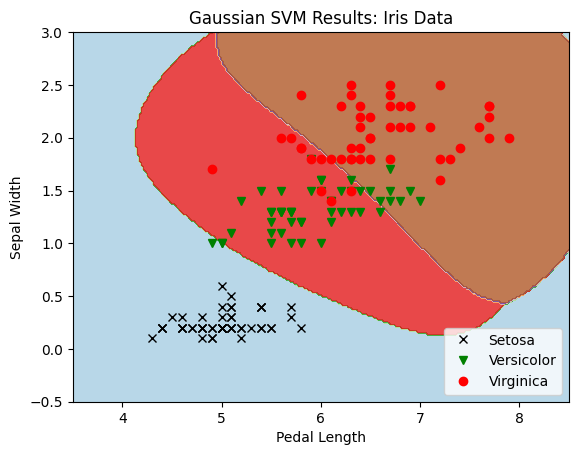

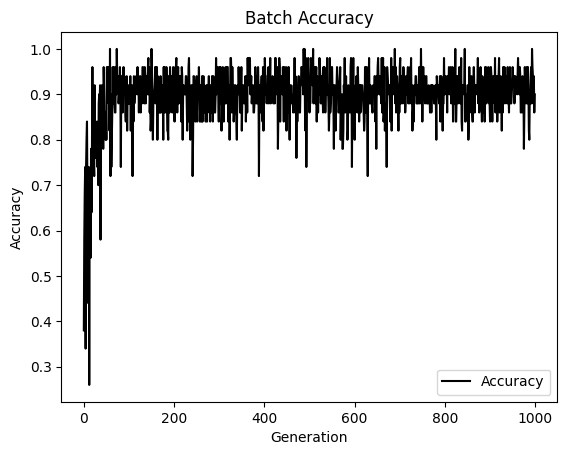

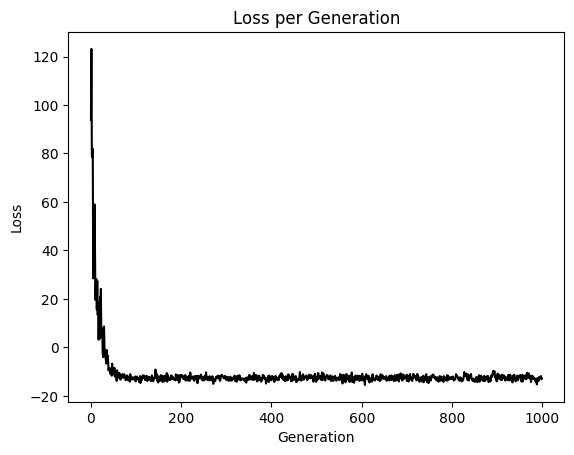

In [ ]:
plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired,
alpha=0.8)
plt.plot(class1_x, class1_y, 'kx', label='Setosa')
plt.plot(class2_x, class2_y, 'gv', label='Versicolor')
plt.plot(class3_x, class3_y, 'ro', label='Virginica')
plt.title('Gaussian SVM Results: Iris Data')
plt.xlabel('Pedal Length')
plt.ylabel('Sepal Width')
plt.legend(loc='lower right')
plt.ylim([-0.5, 3.0])
plt.xlim([3.5, 8.5])
plt.show()

plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

Vẽ đường biên phân loại, đồ thị độ chính xác và biểu đồ mất mát trên dữ liệu Iris để trực quan hóa mô hình Gaussian SVM.
Mô hình phân chia không gian thành ba vùng rõ ràng, tương ứng với ba loại hoa, với độ chính xác tốt, mặc dù dữ liệu gần biên có thể gây lỗi phân loại.
Biểu đồ độ chính xác cho thấy mô hình ổn định trong suốt quá trình huấn luyện.
Biểu đồ mất mát giảm và ổn định sau 200 vòng lặp, cho thấy mô hình đã hội tụ.